# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.


Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.



## Data Understanding

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import datetime
import progressbar
import os

import re
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [2]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

* portfolio.json - Contains offer identifiers and offer meta data (e.g. duration, type, etc.)
* profile.json - Customer demographic data
* transcript.json - Describes customer transactions and when offers are received, viewed, and completed.

## Cleaning and Exploratory analysis

###  Profile dataset

In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


###### Customer profile record attributes: 

age (int) - Customer age

became_member_on (int) - Date when customer created an app account

gender (str) - Customer gender (note some entries contain 'O' for other 

rather than M or F)

id (str) - Customer id

income (float) - Customer's income

 Number of customers: 17000

 Number of colunms: 5

In [5]:
#rename person col name to customer_id.
profile.rename(columns={'id':'customer_id'},inplace=True)

In [6]:
#finding unique customer
len(profile['customer_id'].unique())

17000

In [7]:
#Check missing values
profile.isnull().sum(0)

gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
dtype: int64

In [8]:
#Drop the rows with missing gender income
profile.dropna(inplace=True)

In [9]:
profile['gender'].value_counts().sort_values(ascending=False)

M    8484
F    6129
O     212
Name: gender, dtype: int64

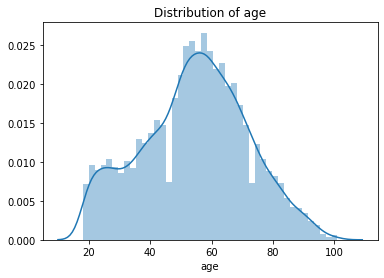

In [10]:
# Plot distribution of ages in profile dataframe 
ax = sns.distplot(profile['age']);
ax.set_title('Distribution of age');

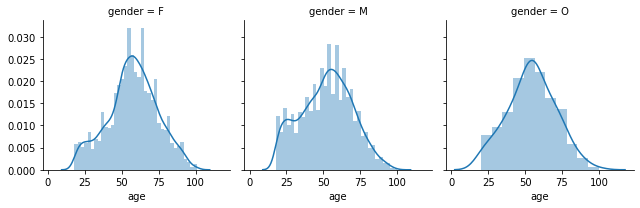

In [11]:
#plot Age distribution by gender
g = sns.FacetGrid(profile, col='gender', col_wrap=3)
g.map(sns.distplot, 'age');

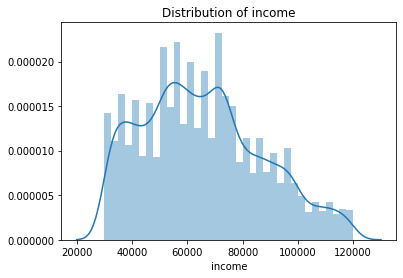

In [12]:
ax = sns.distplot(profile['income']);
ax.set_title('Distribution of income');

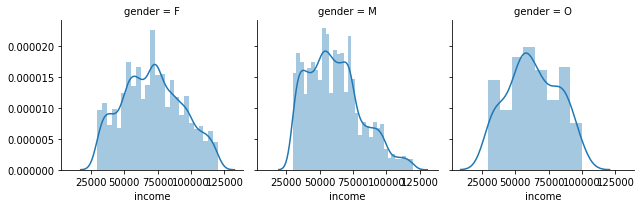

In [13]:
#plot Income distribution by gender
g = sns.FacetGrid(profile, col='gender', col_wrap=3)
g.map(sns.distplot, 'income');

### Portfolio dataset

In [14]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


###### The information provided about the offers is that there are 3 different types of offers:

BOGO - Buy One Get One For Free

Discount - discount upon purchase

Informative - provides information about products

In [15]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   customer_id       14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [16]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [17]:
portfolio['offer_type'].count()

10

In [18]:
#Check missing values
portfolio.isnull().sum(0)

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

###### There is no null values in portfolio database

In [19]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [20]:
#rename id col name to offer_id.
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

#Encode categorical features one hot coding

for index, row in portfolio.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in portfolio.loc[index, 'channels']:
            portfolio.loc[index, channel] = 1
        else:
            portfolio.loc[index, channel] = 0
portfolio.drop(columns='channels', inplace=True)


for index, row in portfolio.iterrows():
    for offertype in ['bogo', 'informational', 'discount']:
        if offertype in portfolio.loc[index, 'offer_type']:
            portfolio.loc[index, offertype] = 1
        else:
            portfolio.loc[index, offertype] = 0
portfolio.drop(columns='offer_type', inplace=True)

In [21]:
portfolio

,reward,difficulty,duration,offer_id,web,email,social,mobile,bogo,informational,discount
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0.0,0.0,1.0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,1.0,0.0,1.0,0.0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [22]:
portfolio.duplicated().sum()

0

### Transcript dataset

In [23]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [24]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


###### Customer transaction record attributes :

event (str) - Record description (i.e. transaction, offer received, offer viewed, etc.)

person (str) - Customer id

time (int) - Time in hours. The data begins at time t=0

value - (dict of strings) - Either an offer id or transaction amount depending on the record

In [25]:
#rename person col name to customer_id.
transcript.rename(columns={'person': 'customer_id'}, inplace=True )

In [26]:
#Check missing values
transcript.isnull().sum()

customer_id    0
event          0
value          0
time           0
dtype: int64

###### There is no null values in transcript database

In [27]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [28]:
#create separate columns for amount and offer_id from value col.

def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]
    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)

# change amount column type to float
transcript.amount.astype('float')

# drop value column
transcript.drop(columns=['value'], inplace=True)

In [29]:
#drop transaction rows whose customer_id is not in profile:customer_id

transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [30]:
transcript['time'] /= 24.0

In [31]:
#segregate offer and transaction data 

# extract transactions from transcript data
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
12659,54890f68699049c2a04d415abc25e717,0.00,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
...,...,...,...
306526,24f56b5e1849462093931b164eb803b5,29.75,22.64
306529,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53
306531,a00058cf10334a308c68e7631c529907,29.75,3.61


In [32]:
#seggregate offer and transaction data 

# extract offer-related from transcript data
offers_df = transcript[transcript.event!='transaction'].copy()

# one-hot encode offer event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount'], inplace=True)

In [33]:
transcript.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [34]:
offers_df.viewed.sum(), offers_df.completed.sum(), offers_df.received.sum()

(49860, 32444, 66501)

## Combine Customer Transaction, Demographic and Offer Data

In [35]:
#Combine offer, customer and transactions data

def combine_data(profile, portfolio, offers_df, transaction_df):
    data = []
    customer_ids = offers_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers_df
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        # get customer id from the list
        cust_id = customer_ids[ind]
        
        # extract customer profile from profile data
        customer = profile[profile['customer_id']==cust_id]
        
        # extract offers associated with the customer from offers_df
        cust_offer_data = offers_df[offers_df['customer_id']==cust_id]
        
        # extract transactions associated with the customer from transactions_df
        cust_transaction_data = transaction_df[transaction_df['customer_id']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data

In [36]:
data = combine_data(profile, portfolio, offers_df, transaction_df)

 [Elapsed Time: 0:20:41] |##################################| (Time:  0:20:41) 


In [37]:
data.head(10)

,offer_id,customer_id,time,total_amount,offer_successful,reward,difficulty,duration,web,email,social,mobile,bogo,informational,discount,gender,age,became_member_on,income
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,5,5,7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,F,75,20170509,100000.0
1,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,7.0,49.39,0,0,0,3,0.0,1.0,1.0,1.0,0.0,1.0,0.0,F,75,20170509,100000.0
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,1,10,10,7,0.0,1.0,1.0,1.0,1.0,0.0,0.0,F,75,20170509,100000.0
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,21.0,48.28,1,5,5,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,F,75,20170509,100000.0
4,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0.00,0,2,10,7,1.0,1.0,0.0,1.0,0.0,0.0,1.0,M,68,20180426,70000.0
5,3f207df678b143eea3cee63160fa8bed,e2127556f4f64592b11af22de27a7932,14.0,0.00,0,0,0,4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,M,68,20180426,70000.0
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,17.0,18.42,1,5,5,7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,M,68,20180426,70000.0
7,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,21.0,18.42,1,2,10,10,1.0,1.0,1.0,1.0,0.0,0.0,1.0,M,68,20180426,70000.0
8,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,9.54,1,5,5,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,M,65,20180209,53000.0
9,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,7.0,0.00,0,5,5,7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,M,65,20180209,53000.0


## How many customers were provided with a specific offer?
Offer success rate (percent success)

In [38]:
def calculate_percentage_success():
    successful_count = data[['offer_id', 'offer_successful']].groupby(
        'offer_id').sum().reset_index()

    offer_count = data['offer_id'].value_counts()

    offer_count = pd.DataFrame(list(zip(offer_count.index.values,
                                        offer_count.values)),
                               columns=['offer_id', 'count'])

    successful_count = successful_count.sort_values('offer_id')

    offer_count = offer_count.sort_values('offer_id')

    percent_success = pd.merge(offer_count, successful_count, on="offer_id")

    percent_success['percent_success'] = (
        100 * percent_success['offer_successful'] / percent_success['count'])

    percent_success = pd.merge(percent_success, portfolio, on="offer_id")

    percent_success = percent_success.drop(columns=['offer_successful'])

    percent_success = percent_success.sort_values('percent_success', ascending=False)

    return percent_success.reset_index(drop=True)

In [39]:
percent_success = calculate_percentage_success()
percent_success

,offer_id,count,percent_success,reward,difficulty,duration,web,email,social,mobile,bogo,informational,discount
0,fafdcd668e3743c1bb461111dcafc2a4,6652,75.285628,2,10,10,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.742299,3,7,7,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2,f19421c1d4aa40978ebb69ca19b0e20d,6576,61.618005,5,5,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,ae264e3637204a6fb9bb56bc8210ddfd,6683,54.646117,10,10,7,0.0,1.0,1.0,1.0,1.0,0.0,0.0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,51.721523,10,10,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,48.287210,5,5,7,1.0,1.0,0.0,1.0,1.0,0.0,0.0
6,2906b810c7d4411798c6938adc9daaa5,6631,47.730357,2,10,7,1.0,1.0,0.0,1.0,0.0,0.0,1.0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,45.762712,5,20,10,1.0,1.0,0.0,0.0,0.0,0.0,1.0
8,3f207df678b143eea3cee63160fa8bed,6657,7.721196,0,0,4,1.0,1.0,0.0,1.0,0.0,1.0,0.0
9,5a8bc65990b245e5a138643cd4eb9837,6643,6.277284,0,0,3,0.0,1.0,1.0,1.0,0.0,1.0,0.0


Text(0, 0.5, 'Success percentage')

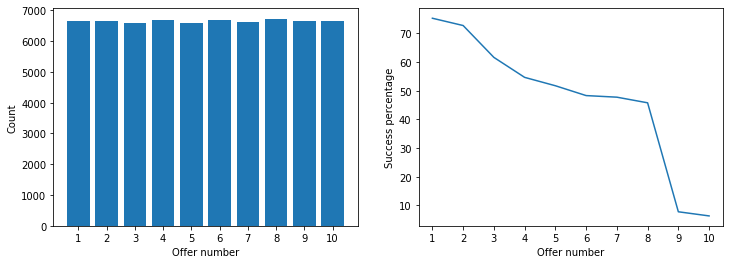

In [40]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

ax[0].bar(percent_success.index + 1, percent_success['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer number')
ax[0].set_ylabel('Count')

ax[1].plot(percent_success.index + 1, percent_success['percent_success'])
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer number')
ax[1].set_ylabel('Success percentage')

## Predict Customer Offer Success

#### Build models


In [41]:
# factors/features that influence the label variable
features = data.drop(columns=['offer_successful'])

# label variable to predict
label = data.filter(['offer_successful'])

# split data into train and test sets
(X_train,
X_test,
y_train,
y_test) = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

# train-data: extract offer_id, total_amount and convert other features to float 
offer_id_train = X_train[:, 0]
total_amount_train = X_train[:, 1]
X_train = X_train[:, 2:]

# test-data: extract offer_id, total_amount and convert other features to float 
offer_id_test = X_test[:, 0]
total_amount_test = X_test[:, 1]
X_test = X_test[:, 2:]

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

In [42]:
#Evaluate Naive Predictor Performance

naive_predictor_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.471
Naive predictor f1-score: 0.640
